In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import numpy as np
from datetime import timedelta

import constants as cst

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from xgboost import XGBClassifier, plot_tree, plot_importance

/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
training_data = pd.read_csv(os.path.join('..', cst.FEATURES_PATH), index_col=0)
training_target = pd.read_csv(os.path.join('..', cst.TRAIN_TARGET_PATH), index_col=0)

In [4]:
full_training_data = pd.merge(training_data, training_target, on='client_id', how='left')
full_training_data.dropna(inplace=True)

In [5]:
train_set, test_set = train_test_split(full_training_data, test_size=0.3, random_state=42)

## Extract label

In [6]:
y_train = train_set['is_churn']
train_set.drop(columns=['is_churn'], inplace=True)

y_test = test_set['is_churn']
test_set.drop(columns=['is_churn'], inplace=True)

## Transformer

In [7]:
scale_nume_cols = [
    'mean_qty',
    'mean_sales',
    'n_branch',
    'n_product',
    'purchase_freq',
    'n_purchases',
    # 'client_age',
    # 'time_from_last_purchase',
    # 'client_lifetime',
]
unscaled_num_cols = [
    'max_qty', 
    'min_qty', 
    'std_qty', 
    'last_qty_1',
    'last_qty_2',
    'last_qty_3',
    'last_qty_4',
    'max_sales',
    'min_sales', 
    'std_sales', 
    'last_sales_1',
    'last_sales_2',
    'last_sales_3',
    'last_sales_4', 
    'delay_purchase_n1',
    'delay_purchase_n2',
    'delay_purchase_n3',
    'delay_purchase_n4',
]
drop_cols = ['client_id', 'frequency', 'client_category', 'time_from_last_purchase', 'client_lifetime', 'client_age']

In [8]:
transformer = make_column_transformer(
    (StandardScaler(), scale_nume_cols),
    ('passthrough', unscaled_num_cols),
    ('drop', drop_cols)
)

## Fitting model

In [9]:
pipeline = make_pipeline(
    transformer, XGBClassifier()
)

In [10]:
pipeline.fit(train_set, y_train)

/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['mean_qty', 'mean_sales',
                                                   'n_branch', 'n_product',
                                                   'purchase_freq',
                                                   'n_purchases']),
                                                 ('passthrough', 'passthrough',
                                                  ['max_qty', 'min_qty',
                                                   'std_qty', 'last_qty_1',
                                                   'last_qty_2', 'last_qty_3',
                                                   'last_qty_4', 'max_sales',
                                                   'min_sales', 'std_sales',
                                                   'last_sales_1',
       

## Evaluating model

In [11]:
train_pred = pipeline.predict(train_set)
test_pred = pipeline.predict(test_set)

### Train eval

In [12]:
print(f'Accuracy score: {accuracy_score(train_pred, y_train)}')
print(f'Precision score: {precision_score(train_pred, y_train)}')
print(f'Recall score: {recall_score(train_pred, y_train)}')
print(f'F1 score: {f1_score(train_pred, y_train)}')
print(f'{confusion_matrix(train_pred, y_train)}')

Accuracy score: 0.8829651583554468
Precision score: 0.6399774854006895
Recall score: 0.8444898338130165
F1 score: 0.7281460134486071
[[42146  5117]
 [ 1675  9096]]


### Test eval

In [13]:
print(f'Accuracy score: {accuracy_score(test_pred, y_test)}')
print(f'Precision score: {precision_score(test_pred, y_test)}')
print(f'Recall score: {recall_score(test_pred, y_test)}')
print(f'F1 score: {f1_score(test_pred, y_test)}')
print(f'{confusion_matrix(test_pred, y_test)}')

Accuracy score: 0.8363687532665943
Precision score: 0.5375346034847744
Recall score: 0.7285367468549989
F1 score: 0.6186281859070465
[[17502  2840]
 [ 1230  3301]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

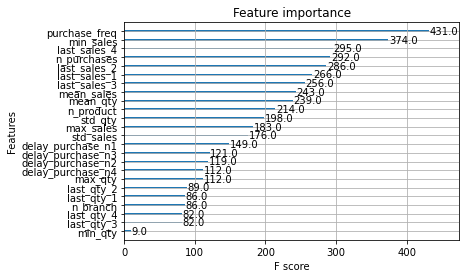

In [14]:
pipeline.steps[1][1].get_booster().feature_names = [name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()]

plot_importance(pipeline.steps[1][1])

## Interpretability

In [15]:
import shap

In [16]:
# load JS visualization code to notebook
shap.initjs()

In [17]:
explainer = shap.TreeExplainer(pipeline.steps[1][1])
shap_values = explainer.shap_values(pipeline.steps[0][1].fit_transform(train_set))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


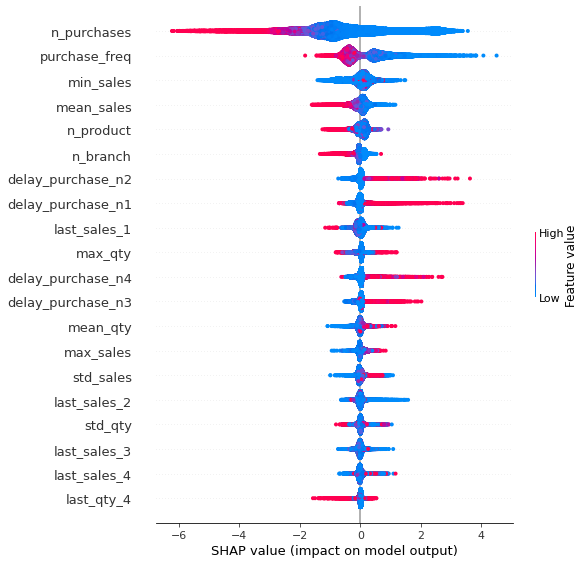

In [18]:
shap.summary_plot(shap_values, features=pipeline.steps[0][1].fit_transform(train_set), 
                  feature_names=[name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()])

In [74]:
train_set.columns

Index(['client_id', 'mean_qty', 'max_qty', 'min_qty', 'std_qty', 'last_qty_1',
       'last_qty_2', 'last_qty_3', 'last_qty_4', 'mean_sales', 'max_sales',
       'min_sales', 'std_sales', 'last_sales_1', 'last_sales_2',
       'last_sales_3', 'last_sales_4', 'n_branch', 'n_product',
       'purchase_freq', 'n_purchases', 'delay_purchase_n1',
       'delay_purchase_n2', 'delay_purchase_n3', 'delay_purchase_n4',
       'client_age', 'time_from_last_purchase', 'client_lifetime',
       'last_purchase', 'frequency', 'client_category', 'val_is_churn'],
      dtype='object')

In [19]:
i = np.argwhere(train_pred==1)[0][0]
shap.force_plot(
    explainer.expected_value, 
    shap_values[i], 
    features=pipeline.steps[0][1].fit_transform(train_set)[i], 
    feature_names=[name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()]
)

## Validation

In [20]:
# retrieve non-churners
val_transactions = pd.read_csv(os.path.join('..', cst.VALIDATION_DATA_PATH), index_col=0)
non_churners = val_transactions['client_id'].unique()

In [21]:
# check whether a client has churned in the validation period
train_set.loc[train_set['client_id'].isin(non_churners), 'val_is_churn'] = 0
train_set.loc[~(train_set['client_id'].isin(non_churners)), 'val_is_churn'] = 1

In [22]:
train_set['val_is_churn'].value_counts(normalize=True)

0.0    0.783299
1.0    0.216701
Name: val_is_churn, dtype: float64

In [23]:
print(f"Accuracy score: {accuracy_score(train_pred, train_set['val_is_churn'])}")
print(f"Precision score: {precision_score(train_pred, train_set['val_is_churn'])}")
print(f"Recall score: {recall_score(train_pred, train_set['val_is_churn'])}")
print(f"F1 score: {f1_score(train_pred, train_set['val_is_churn'])}")
print(f"{confusion_matrix(train_pred, train_set['val_is_churn'])}")

Accuracy score: 0.8554123444877141
Precision score: 0.5946246819338422
Recall score: 0.6942716553709034
F1 score: 0.640596222212704
[[42165  5098]
 [ 3293  7478]]


## Saving predictions

In [27]:
full_training_data['churn_prob'] = pipeline.predict_proba(full_training_data)[:, 1]
full_training_data['churn_pred'] = pipeline.predict(full_training_data)

In [32]:
full_training_data.loc[(full_training_data['client_id'].isin(non_churners)) & (full_training_data['churn_pred']==1), 'actionable'] = 1

In [36]:
full_training_data.to_csv(os.path.join('..', cst.FULL_PREDICTIONS_PATH))

In [73]:
for i in ["mean_qty",
        "mean_sales",
        "n_branch",
        "n_product",
        "purchase_freq",
        "n_purchases",
        "max_qty",
        "min_qty",
        "std_qty",
        "last_qty_1",
        "last_qty_2",
        "last_qty_3",
        "last_qty_4",
        "max_sales",
        "min_sales",
        "std_sales",
        "last_sales_1",
        "last_sales_2",
        "last_sales_3",
        "last_sales_4",
        "delay_purchase_n1",
        "delay_purchase_n2",
        "delay_purchase_n3",
        "delay_purchase_n4",]:
    if i in full_training_data.columns:
        pass
    else:
        print(i)

In [44]:
full_training_data.columns

Index(['client_id', 'mean_qty', 'max_qty', 'min_qty', 'std_qty', 'last_qty_1',
       'last_qty_2', 'last_qty_3', 'last_qty_4', 'mean_sales', 'max_sales',
       'min_sales', 'std_sales', 'last_sales_1', 'last_sales_2',
       'last_sales_3', 'last_sales_4', 'n_branch', 'n_product',
       'purchase_freq', 'n_purchases', 'delay_purchase_n1',
       'delay_purchase_n2', 'delay_purchase_n3', 'delay_purchase_n4',
       'client_age', 'time_from_last_purchase', 'client_lifetime',
       'last_purchase', 'frequency', 'client_category', 'is_churn',
       'churn_prob', 'churn_pred', 'actionable'],
      dtype='object')

In [50]:
(full_training_data
    .loc[full_training_data['actionable']==1, ['client_id', 'churn_prob', 'mean_sales', 'mean_qty', 'n_purchases']]
    .sort_values(by='churn_prob', ascending=False)
    .set_index('client_id')
    .T
)

client_id,796142,1035447,490343,1307363,50792,123211,998433,1714521,45723,118860,...,1147274,1084639,482238,902706,245047,1024949,1430704,1074999,858701,1423102
churn_prob,0.995137,0.993841,0.99238,0.990478,0.989923,0.989769,0.989060,0.988570,0.987416,0.98624,...,0.500782,0.500500,0.500374,0.500289,0.500266,0.500263,0.500172,0.500131,0.500104,0.500091
mean_sales,16.387347,136.950740,1701.02112,297.440089,61.763280,410.545400,76.990857,158.654511,142.884543,21.91440,...,249.760771,158.560460,103.351956,58.904669,198.707361,446.572458,95.598120,184.346840,157.553652,145.758313
mean_qty,11.400000,12.000000,3.00000,5.444444,3.000000,3.000000,5.000000,6.333333,13.857143,4.60000,...,43.538462,23.237288,24.675676,19.901408,32.454545,53.792453,11.400000,3.800000,39.608696,21.611111
n_purchases,5.000000,6.000000,10.00000,9.000000,5.000000,6.000000,7.000000,6.000000,7.000000,5.00000,...,26.000000,59.000000,37.000000,142.000000,187.000000,53.000000,5.000000,5.000000,23.000000,36.000000


In [56]:
explainer = shap.TreeExplainer(pipeline.steps[1][1])
shap_values = explainer.shap_values(pipeline.steps[0][1].fit_transform(full_training_data))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [59]:
np.save(os.path.join('..', cst.SHAP_VALUES_PATH), shap_values)

In [62]:
import pickle

with open(os.path.join('..', cst.EXPLAINER_PATH), 'wb') as f:
    pickle.dump(explainer, f)

In [64]:
with open(os.path.join('..', cst.PIPELINE_PATH), 'wb') as f:
    pickle.dump(pipeline, f)

In [87]:
full_training_data.columns

Index(['client_id', 'mean_qty', 'max_qty', 'min_qty', 'std_qty', 'last_qty_1',
       'last_qty_2', 'last_qty_3', 'last_qty_4', 'mean_sales', 'max_sales',
       'min_sales', 'std_sales', 'last_sales_1', 'last_sales_2',
       'last_sales_3', 'last_sales_4', 'n_branch', 'n_product',
       'purchase_freq', 'n_purchases', 'delay_purchase_n1',
       'delay_purchase_n2', 'delay_purchase_n3', 'delay_purchase_n4',
       'client_age', 'time_from_last_purchase', 'client_lifetime',
       'last_purchase', 'frequency', 'client_category', 'is_churn',
       'churn_prob', 'churn_pred', 'actionable'],
      dtype='object')

In [229]:
train_labels = pd.read_csv('../data/train/training_labels.csv', index_col=0)
features = pd.read_csv('../data/train/features.csv', index_col=0)

In [147]:
full_dataset = pd.merge(features, train_labels, how='left')

In [149]:
full_dataset.columns

Index(['client_id', 'mean_qty', 'max_qty', 'min_qty', 'std_qty', 'last_qty_1',
       'last_qty_2', 'last_qty_3', 'last_qty_4', 'mean_sales', 'max_sales',
       'min_sales', 'std_sales', 'last_sales_1', 'last_sales_2',
       'last_sales_3', 'last_sales_4', 'n_branch', 'n_product',
       'purchase_freq', 'n_purchases', 'delay_purchase_n1',
       'delay_purchase_n2', 'delay_purchase_n3', 'delay_purchase_n4',
       'client_age', 'time_from_last_purchase', 'client_lifetime',
       'last_purchase', 'frequency', 'client_category', 'is_churn'],
      dtype='object')

In [152]:
test = full_dataset.groupby(by="client_category").agg(
    {
        'client_id': "count", 
        "mean_sales": "mean", 
        "mean_qty": "mean",
        "is_churn": "sum"
    }
)

In [210]:
test_2 = full_training_data.groupby(by=["client_category", "is_churn"], as_index=False).agg(
    {
        'client_id': "count", 
    }
)

([<matplotlib.patches.Wedge at 0x2e82d0be0>,
 [Text(-0.6992027810984013, 0.8491851805726837, 'No churn'),
  Text(0.6992027015919435, -0.8491852460367689, 'Churn')],
 [Text(-0.38138333514458245, 0.46319191667600923, '72%'),
  Text(0.38138329177742375, -0.4631919523836921, '28%')])

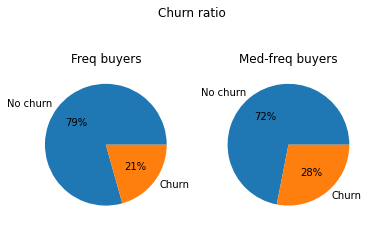

In [211]:
fig, ax = plt.subplots(1, 2)
plt.suptitle('Churn ratio')
ax[0].title.set_text('Freq buyers')
ax[0].pie(test_2.loc[test_2['client_category']=='freq_buyer', 'client_id'], labels=['No churn', 'Churn'], autopct='%.0f%%')
ax[1].title.set_text('Med-freq buyers')
ax[1].pie(test_2.loc[test_2['client_category']=='med_buyer', 'client_id'], labels=['No churn', 'Churn'], autopct='%.0f%%')

In [230]:
transactions = pd.read_csv('../data/validation/val_transactions.csv', nrows=1_000_000, index_col=0)
transactions_labels = pd.merge(transactions, train_labels, how='left')

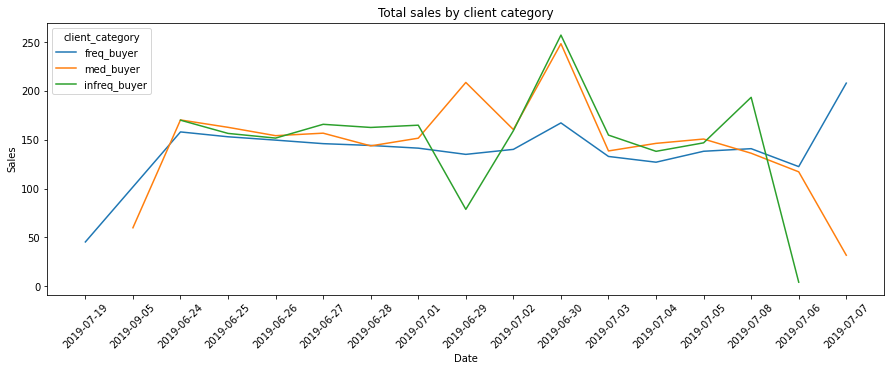

In [231]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Total sales by client category")
plt.xlabel("Date")
plt.ylabel("Sales")
sns.lineplot(data=transactions_labels, x='date_order', y='sales_net', hue='client_category', ci=None)
for item in ax.get_xticklabels():
    item.set_rotation(45)

Text(330, 15, 'size: # clients')

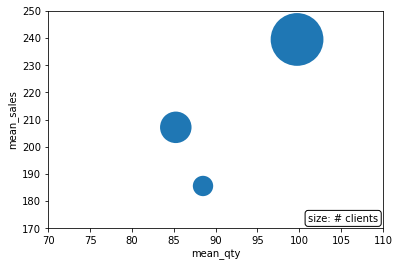

In [187]:
fig, ax = plt.subplots()
ax.set_xlim(70, 110)
ax.set_ylim(170, 250)
sns.scatterplot(data=test, x='mean_qty', y='mean_sales', size='client_id', sizes=(500, 3000), legend=False)
annotations = [""]

ax.annotate("size: # clients", xy=(330, 15), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
# plt.legend(labels=["size: # clients"], loc='lower right', prop={'size': 10})